In [1]:
import os
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from model_LSTM import AlexNet
import matplotlib
from matplotlib import pyplot as plt
import copy as copy1

# import math
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

import pylab
from pylab import *
import matplotlib as mpl

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from xgboost import XGBClassifier

mpl.rcParams['font.sans-serif'] = ['Times New Roman']
# ！
mpl.rcParams['axes.unicode_minus'] = False
# 用来正常显示负号
from matplotlib.ticker import FuncFormatter
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

def to_percent(temp, position):
    return '%1.0f' % (100 * temp) + '%'

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
#coding=utf-8
# -*- coding: utf-8 -*-
import os
from os.path import isdir
import linecache
# python自带的模块，缓存读取文件某一行的内容
import numpy as np
import pandas as pd
import math
import copy as copy1
import scipy
import urllib
# from scipy.signal import savgol_filter
import urllib.parse
from urllib.parse import urlparse
import sys
from numpy import loadtxt
from numpy import savetxt
from numpy.linalg import svd

import pylab
from pylab import *
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
#！
mpl.rcParams['axes.unicode_minus']=False
#用来正常显示负号
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy.signal import find_peaks_cwt
from scipy.sparse import linalg
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
from scipy.cluster import hierarchy
from scipy import cluster
#用于进行层次聚类，话层次聚类图的工具包
import sklearn
from sklearn import decomposition as skldec
#用于主成分分析降维的包
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
#tsne
import joblib
#保存、加载分类器模型
#tree
import sys
#from sklearn.externals.six import StringIO
from six import StringIO
import pydotplus
import graphviz
from skimage import filters
from sklearn import tree #树的模块
#基于Otsu的阈值分割方法,无参数去背景
#forest
import math
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
#from sklearn.externals.six import StringIO
import pydotplus
from sklearn.metrics import classification_report
#高斯朴素贝叶斯
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

#xgboost
import xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_tree
import matplotlib.pyplot as plt
#LightGBM
from sklearn.datasets import load_iris
import lightgbm as lgb


#ROCq曲线AUC值
# from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp
#画图-混淆矩阵
import seaborn as sns
from sklearn.metrics import confusion_matrix
#-----------------------
import struct
# Kmeans模型
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

#写入word
import docx
import docx.enum
import docx.shared
import docx.enum.text
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
import docx.oxml
import docx.oxml.ns
from docx.oxml.ns import qn
from sklearn import tree               #导入模型
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

d:\miniconda3\envs\pytorch\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [22]:
class SegModelGRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.features = torch.nn.Sequential(
            # torch.nn.Linear(in_features=input_size, out_features=hidden_size),
            torch.nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=True),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_size, 2*hidden_size),
            #torch.nn.Linear(input_size, 2*hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),

            torch.nn.Linear(2 * hidden_size, 2 * hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
        )
        self.output = torch.nn.Linear(2*hidden_size, out_size)

    def forward(self, x):
        """
        :param x: shape(batch, seq_len, input_size)
        :return:
        """
        batch, seq_len, nums_fea = x.size()
        features, _ = self.features(x)
        output = self.classifier(features)
        output = self.output(output.view(batch * seq_len, -1))
        return output


In [19]:
class SegModelLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.features = torch.nn.Sequential(
            # torch.nn.Linear(in_features=input_size, out_features=hidden_size),
            torch.nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=True),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2*hidden_size, 2*hidden_size),
            #torch.nn.Linear(input_size, 2*hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),

            torch.nn.Linear(2 * hidden_size, 2 * hidden_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
        )
        self.output = torch.nn.Linear(2*hidden_size, out_size)

    def forward(self, x):
        """
        :param x: shape(batch, seq_len, input_size)
        :return:
        """
        batch, seq_len, nums_fea = x.size()
        features, _ = self.features(x)
        output = self.classifier(features)
        output = self.output(output.view(batch * seq_len, -1))
        return output


In [3]:
data_train = pd.read_csv(r'./data/胃癌-病理分期-PCA+SPEC+PCA_HHT+SPEC_HHT - 副本.txt',sep='\t',header=None)
data_train = np.array(data_train)



##光谱PCA=0.95
data_train_pcaspec_x = data_train[:,1:11]
data1_train_pcaspec_y = data_train[:,0]
data_train_pcaspec, data_test_pcaspec, label_train_pcaspec, label_test_pcaspec = train_test_split(data_train_pcaspec_x,data1_train_pcaspec_y,shuffle=False,test_size=0.2)
##光谱
data_train_spec_x = data_train[:,11:1338]
data1_train_spec_y = data_train[:,0]
data_train_spec, data_test_spec, label_train_spec, label_test_spec = train_test_split(data_train_spec_x,data1_train_spec_y,shuffle=False,test_size=0.2)

##HHT滤波的光谱PCA=0.95
data_train_pcahht_x = data_train[:,1338:1368]
data1_train_pcahht_y = data_train[:,0]
data_train_pcahht, data_test_pcahht, label_train_pcahht, label_test_pcahht = train_test_split(data_train_pcahht_x,data1_train_pcahht_y,shuffle=False,test_size=0.2)
##HHT滤波的光谱
data_train_spechht_x = data_train[:,1368:2695]
data1_train_spechht_y = data_train[:,0]
data_train_spechht, data_test_spechht, label_train_spechht, label_test_spechht = train_test_split(data_train_spechht_x,data1_train_spechht_y,shuffle=False,test_size=0.2)


736
73
663
736
(736,)
(736, 10)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])


 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.83s/it]

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([23, 2])
[1,     1] train_loss: 0.006  test_accuracy: 62.745
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([23, 2])


 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:05,  1.81s/it]

[2,     1] train_loss: 0.005  test_accuracy: 77.225
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:05<00:03,  1.78s/it]

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([23, 2])
[3,     1] train_loss: 0.005  test_accuracy: 77.225
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([23, 2])


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:07<00:01,  1.75s/it]

[4,     1] train_loss: 0.005  test_accuracy: 77.225
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([23, 2])


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]

[5,     1] train_loss: 0.004  test_accuracy: 77.225
Finished Training
(184, 10) (184,)


Predicted 184 spectra: 1.75s
Accuracy: 81.0%
[[  0. 100.]
 [  0. 100.]]
['1', '2', '3', '4', '5', '6', '7', '8', '9']


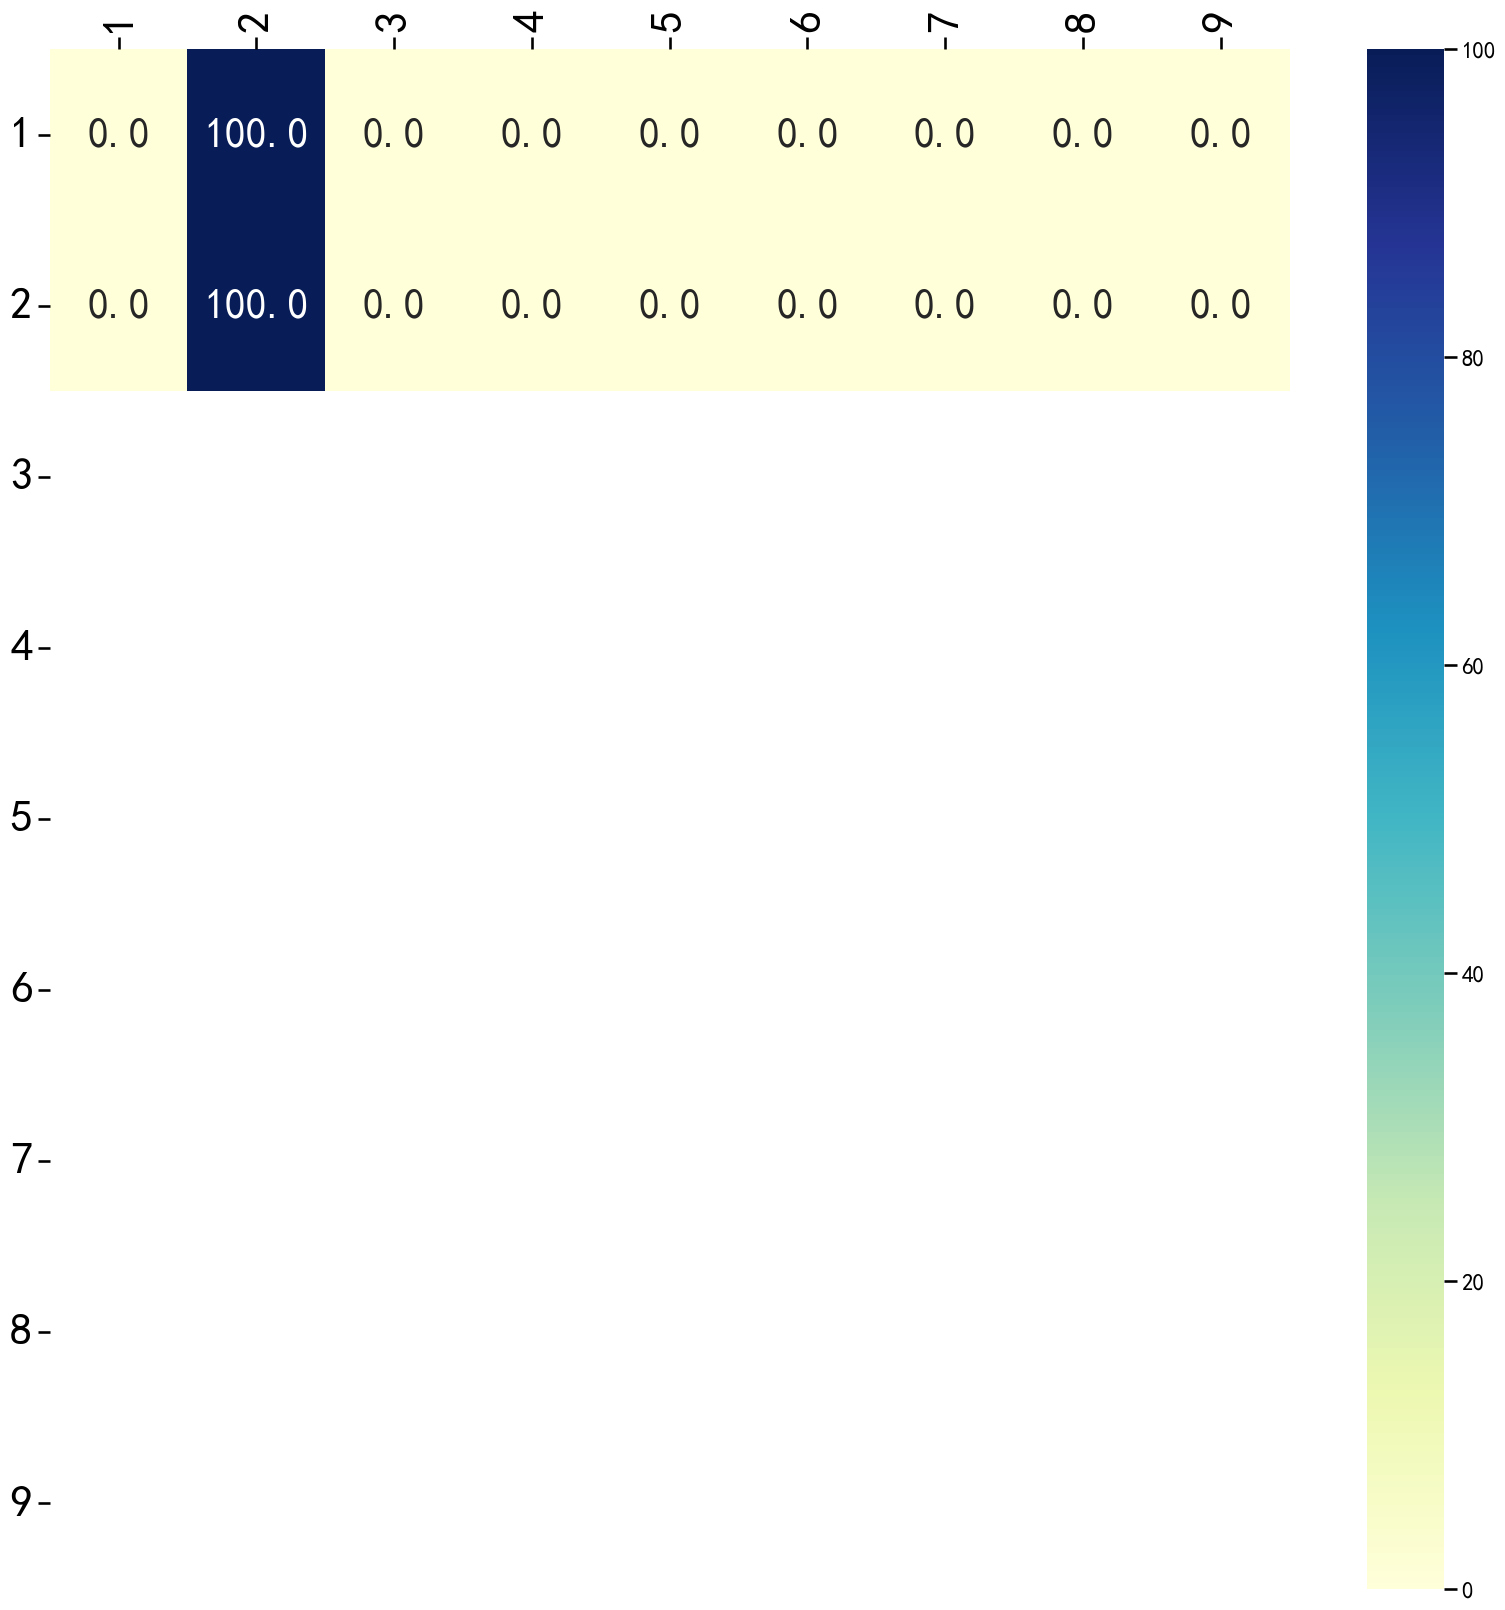

In [24]:
X=data_train_pcaspec
x_train=data_train_pcaspec
y=label_train_pcaspec
y_train=label_train_pcaspec
X_test = data_test_pcaspec
y_test=label_test_pcaspec

#####################################################################################################################################
#####################################################################################################################################
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers

in_channels = 64
n_classes =  2
m_batch_size = 128
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

#####################################################################################################################################
#####################################################################################################################################
n_classes=2
net = SegModelGRU(input_size=X.shape[1], hidden_size=100, num_layers=2, out_size=n_classes)
net = net.cuda()

#####################################################################################################################################
#####################################################################################################################################
from datasets import spectral_dataloader
#from training import run_epoch
from torch import optim
X_rows = x_train.shape[0]
print(X_rows)
p_val = 0.1
n_val = int(X_rows* p_val)
idx_tr = list(range(X_rows))
np.random.shuffle(idx_tr)
idx_val = idx_tr[:n_val]
idx_tr = idx_tr[n_val:]
print(len(idx_val))
print(len(idx_tr))
print(X_rows)
print(y_train.shape)
print(x_train.shape)


#####################################################################################################################################
#####################################################################################################################################
#print(y.shape)
from time import time
t00 = time()
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable # torch 中 Variable 模块
%matplotlib inline
epochs = 30 # Change this number to ~30 for full training
t0 = time()
batch_size = 128
# Set up Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.5, 0.999))
# Set up dataloaders
dl_tr = spectral_dataloader(X, y, idxs=idx_tr,
    batch_size=batch_size, shuffle=True)
dl_val = spectral_dataloader(X, y, idxs=idx_val,
    batch_size=batch_size, shuffle=False)

#for batch_idx, (inputs, targets) in enumerate(dl_tr):
#    print(inputs)
    
#inputs, targets = Variable(inputs), Variable(targets.long())
#print(dl_tr.shape)
#print(dl_val.shape)



#####################################################################################################################################

#####################################################################################################################################
#定义两个数组
Loss_list = []
Accuracy_list = []

from torch.autograd import Variable # torch 中 Variable 模块
import torch.nn as nn
from tqdm import tqdm
loss_function = nn.CrossEntropyLoss()
min_loss = 100000#随便设置一个比较大的数
#optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
#定义两个数组
Loss_list = []
Accuracy_list = []

for epoch in tqdm(range(1000)):  # loop over the dataset multiple times###############################################################
    
    total_loss = 0
    correct = 0
    total = 0  
   # running_loss = 0.0
    for batch_idx,  (inputs, targets) in enumerate(dl_tr, start=0):
            # get the inputs; data is a list of [inputs, labels]
        inputs, targets = Variable(inputs), Variable(targets.long())
        inputs=inputs.cuda()
        targets=targets.cuda()
        #print(targets.shape)
        #print(inputs.shape)
        outputs = net(inputs)
        print(outputs.shape)

        loss = nn.CrossEntropyLoss()(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).sum().item()
    

    acc = 100 * correct / total
    avg_loss = total_loss / total
    Loss_list.append(avg_loss)
    Accuracy_list.append(acc)
    print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                (epoch + 1,  1, avg_loss , acc))

print('Finished Training')

#我这里迭代了200次，所以x的取值范围为(0，200)，然后再将每次相对应的准确率以及损失率附在x上
x1 = range(0, 1000)
x2 = range(0, 1000)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
#plt.show()
plt.savefig("GRU_WB_PCA_accuracy_loss.tif", format='tif', bbox_inches='tight', transparent=True, dpi=300)

save_path = './GRU.pth'
torch.save(net.state_dict(), save_path)
torch.save(net, 'GRU_WB_PCA.pkl')

#####################################################################################################################################
#####################################################################################################################################
#y_test = np.load(y_test_npy_path)
print(X_test.shape, y_test.shape)
from training import get_predictions
from datasets import spectral_dataloader
# Make predictions on subset of data
t0 = time()
#net = net.cuda()
##########################加载保存的模型
net = torch.load('GRU_WB_PCA.pkl').cuda()
#net = net.cuda()
#net = net.cuda()
dl = spectral_dataloader(X_test, y_test, batch_size=2, shuffle=False)
y_hat = get_predictions(net, dl, cuda)
print('Predicted {} spectra: {:0.2f}s'.format(len(y_hat), time()-t0))
# Computing accuracy
acc = (y_hat == y_test).mean()
print('Accuracy: {:0.1f}%'.format(100*acc))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_hat)
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
print(cm)


#####################################################################################################################################
#####################################################################################################################################
import seaborn as sns
from sklearn.metrics import confusion_matrix
from config1998 import ORDER, STRAINS
%matplotlib inline
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":30})
label = [STRAINS[i] for i in ORDER]
print(label)
cm = confusion_matrix(y_test, y_hat, labels=ORDER)
plt.figure(figsize=(20,20))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.1f',xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.xticks(fontsize= 32)
plt.yticks(rotation=0) 
plt.yticks(fontsize= 32)
plt.plot()
plt.show()